In [3]:
from models.ICA_EM import *
from models.dgp import *
from models.metrics import *
import importlib, sys
importlib.reload(sys.modules['models.ICA_EM'])
importlib.reload(sys.modules['models.dgp'])
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [223]:
data = dgp(prior={"loc" : 0, "scale" : 1/np.sqrt(2)})
n = 10000
J = 6
I = 5
data.generate_data(n=n, J=J, I=I, random_state=10)

In [224]:
print(np.round(data.mixing_matrix_observed, 2))

[[ 1.    0.    2.3  -1.2   0.    0.  ]
 [-2.55  1.   -4.28  3.22 -2.58 -1.62]
 [ 0.    0.    0.    1.    0.   -0.  ]
 [-0.   -0.   -0.   -1.15  1.   -0.32]
 [ 0.    0.    0.    0.    0.    1.  ]]


In [234]:
def norm_funtion(A):
    # [0,0], [1,1] must be one
    A_0 = A[:, 0]/A[0,0]
    return A_0

In [254]:
class CausalVarEM(VarEM):
    def __init__(self, update_sigma=True, true_A=None, tol=1e-4, **kwargs):
        super().__init__(update_sigma=update_sigma, true_A=true_A, tol=tol, **kwargs)
    
    def update_A(self): # we can force causal structure 
        temp1 = np.zeros((self.I, self.J))
        temp2 = np.zeros((self.J, self.J))
        #self.A[:,0] = self.A[:,0]/self.A[0,0]
        #self.A[:,1] = self.A[:,1]/self.A[1,1]
        #self.A[0,1] = 0
        
        for i in range(self.n):
            omega_i = self._omega_mat(i)
            M_i = self._M_mat(omega_i)
            x_outer = np.outer(self.X[i,:], self.X[i,:])
            temp1 += x_outer @ M_i.T @ self.A @ omega_i
            temp2 += omega_i @ (np.eye(self.J) - self.A.T @ M_i @ (np.eye(self.I) - x_outer @ M_i.T) @ self.A @ omega_i)
            self._update_xi(i, M_i, omega_i, x_outer)
        A_new = temp1 @ np.linalg.inv(temp2)
        if self.update_sigma:
            self._update_sigma(A_new)


        # calculate the difference between the old and new A
        diff = np.linalg.norm(self.A - A_new, ord='fro')
        self.A = A_new
        return diff
    
    def _initilize_A(self):
        super()._initilize_A()
        self.A[0,1] = 0
        #self.A[2:J, 0] = 0
        # set ones
        self.A[0,0] = 1
        self.A[1,1] = 1
        # set controls to 1
        for j in range(2, J-1):
            self.A[j,j+1] = 1
            



In [227]:
estimator_Causal = CausalVarEM(update_sigma=False,   true_A= data.mixing_matrix_observed, tol=1e-4, max_iter=200, random_seed=1)
estimator_Causal.fit(data.data_observed, J = J)


Initializing A with true A + noise


Diff: 0.0030: 100%|██████████| 200/200 [00:44<00:00,  4.51it/s]


Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 91269.21it/s]


In [228]:
best_perm, score = f_score(data.mixing_matrix_observed, estimator_Causal.A)    
print(score)

0.29581792146292557


In [235]:
print(np.round(estimator_Causal.A, 2))

NameError: name 'estimator_Causal' is not defined

In [230]:
print(np.round(estimator_Causal.A[:, best_perm], 2))
print(norm_funtion(estimator_Causal.A[:, best_perm]))

[[ 0.57  0.1   1.11 -1.37 -0.44  0.72]
 [-2.99  0.22 -2.18  3.44 -0.3  -2.74]
 [-0.1  -0.12 -0.02  0.9  -0.11 -0.06]
 [ 0.74  0.14  0.01 -1.14  0.38 -0.2 ]
 [-0.04 -0.19 -0.01  0.1   0.13  0.73]]
[ 1.         -5.26669774 -0.17270928  1.30492242 -0.061946  ]


In [231]:
print(np.round(data.mixing_matrix_observed, 2))

[[ 1.    0.    2.3  -1.2   0.    0.  ]
 [-2.55  1.   -4.28  3.22 -2.58 -1.62]
 [ 0.    0.    0.    1.    0.   -0.  ]
 [-0.   -0.   -0.   -1.15  1.   -0.32]
 [ 0.    0.    0.    0.    0.    1.  ]]


In [ ]:
# # plot signals righltly ordered
singals_estimation_VAR = estimator.Signals[:,best_perm]
for i in range(J):
    fig, ax = plt.subplots(1,1,figsize = (8,5))
    sns.scatterplot(x = data.signals[:,i], y = singals_estimation_VAR[:,i], ax = ax)
    ax.title.set_text('VarEM')
    ax.set_xlabel('True signal')
    ax.set_ylabel('Estimated signal')    
    plt.show()

In [255]:
# compare VarEM with CausalVarEM
treatmet_true = []
treatment_var_perm= []
treatment_causal_perm = []
score_var = []
score_causal = []
treatment_var_first_column = []
treatment_causal_first_column = []


data = dgp(prior={"loc" : 0, "scale" : 1/np.sqrt(2)})
for i in tqdm.tqdm(range(100)):
    data.generate_data(n=n, J=J, I=I, random_state=i)
    estimator = VarEM(update_sigma=False,   true_A= data.mixing_matrix_observed, tol=1e-4, max_iter=200, random_seed=i)
    estimator.fit(data.data_observed, J = J, progress_bar=False)
    best_perm, score = f_score(data.mixing_matrix_observed, estimator.A)    
    score_var.append(score)
    treatment_var_perm.append(norm_funtion(estimator.A[:, best_perm])[1])
    treatment_var_first_column.append(norm_funtion(estimator.A)[1])
    estimator_Causal = CausalVarEM(update_sigma=False,   true_A= data.mixing_matrix_observed, tol=1e-4, max_iter=200, random_seed=i)
    estimator_Causal.fit(data.data_observed, J = J, progress_bar=False)
    best_perm, score = f_score(data.mixing_matrix_observed, estimator_Causal.A)    
    score_causal.append(score)
    treatmet_true.append(data.treatment_effect)
    treatment_causal_perm.append(norm_funtion(estimator_Causal.A[:,best_perm])[1])
    treatment_causal_first_column.append(norm_funtion(estimator_Causal.A)[1])


  0%|          | 0/100 [00:00<?, ?it/s]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 95112.39it/s]

Initializing A with true A + noise


Estimating the signals


  1%|          | 1/100 [01:28<2:26:46, 88.96s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92933.12it/s]

Initializing A with true A + noise


Estimating the signals


  2%|▏         | 2/100 [03:00<2:27:51, 90.52s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92245.96it/s]

Initializing A with true A + noise


Estimating the signals


  3%|▎         | 3/100 [04:32<2:27:21, 91.15s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 90513.28it/s]

Initializing A with true A + noise


Estimating the signals


  4%|▍         | 4/100 [06:04<2:26:32, 91.59s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 90464.28it/s]

Initializing A with true A + noise


Estimating the signals


  5%|▌         | 5/100 [07:37<2:25:42, 92.02s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 89706.22it/s]

Initializing A with true A + noise


Estimating the signals


  6%|▌         | 6/100 [09:11<2:24:58, 92.53s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 88486.31it/s]

Initializing A with true A + noise


Estimating the signals


  7%|▋         | 7/100 [10:43<2:23:21, 92.49s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 89988.76it/s]

Initializing A with true A + noise


Estimating the signals


  8%|▊         | 8/100 [12:16<2:21:56, 92.58s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 90780.50it/s]

Initializing A with true A + noise


Estimating the signals


  9%|▉         | 9/100 [13:47<2:19:48, 92.18s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 90620.84it/s]

Initializing A with true A + noise


Estimating the signals


 10%|█         | 10/100 [15:18<2:17:54, 91.94s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 89538.46it/s]

Initializing A with true A + noise


Estimating the signals


 11%|█         | 11/100 [16:51<2:16:36, 92.09s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 89047.07it/s]

Initializing A with true A + noise


Estimating the signals


 12%|█▏        | 12/100 [18:22<2:14:42, 91.85s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 90706.29it/s]

Initializing A with true A + noise


Estimating the signals


 13%|█▎        | 13/100 [19:53<2:12:47, 91.59s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 89798.21it/s]

Initializing A with true A + noise


Estimating the signals


 14%|█▍        | 14/100 [21:24<2:11:08, 91.49s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 85347.75it/s]

Initializing A with true A + noise


Estimating the signals


 15%|█▌        | 15/100 [22:55<2:09:26, 91.37s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 90689.03it/s]

Initializing A with true A + noise


Estimating the signals


 16%|█▌        | 16/100 [24:26<2:07:43, 91.23s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 89678.02it/s]

Initializing A with true A + noise


Estimating the signals


 17%|█▋        | 17/100 [25:57<2:06:05, 91.15s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 72469.65it/s]

Initializing A with true A + noise


Estimating the signals


 18%|█▊        | 18/100 [27:28<2:04:30, 91.10s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 89986.44it/s]

Initializing A with true A + noise


Estimating the signals


 19%|█▉        | 19/100 [28:59<2:02:55, 91.05s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 89407.91it/s]

Initializing A with true A + noise


Estimating the signals


 20%|██        | 20/100 [30:30<2:01:25, 91.06s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 90480.48it/s]

Initializing A with true A + noise


Estimating the signals


 21%|██        | 21/100 [32:01<1:59:48, 90.99s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 90548.26it/s]

Initializing A with true A + noise


Estimating the signals


 22%|██▏       | 22/100 [33:33<1:58:43, 91.33s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 87960.04it/s]

Initializing A with true A + noise


Estimating the signals


 23%|██▎       | 23/100 [35:07<1:58:08, 92.05s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 90114.43it/s]

Initializing A with true A + noise


Estimating the signals


 24%|██▍       | 24/100 [36:39<1:56:26, 91.92s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 90428.98it/s]

Initializing A with true A + noise


Estimating the signals


 25%|██▌       | 25/100 [38:10<1:54:43, 91.77s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 90293.49it/s]

Initializing A with true A + noise


Estimating the signals


 26%|██▌       | 26/100 [39:42<1:53:11, 91.78s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 85911.53it/s]

Initializing A with true A + noise


Estimating the signals


 27%|██▋       | 27/100 [41:13<1:51:28, 91.62s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 90439.51it/s]

Initializing A with true A + noise


Estimating the signals


 28%|██▊       | 28/100 [42:44<1:49:49, 91.53s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 83803.95it/s]

Initializing A with true A + noise


Estimating the signals


 29%|██▉       | 29/100 [44:16<1:48:27, 91.66s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 88193.45it/s]

Initializing A with true A + noise


Estimating the signals


 30%|███       | 30/100 [45:48<1:46:44, 91.49s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 90505.66it/s]

Initializing A with true A + noise


Estimating the signals


 31%|███       | 31/100 [47:18<1:44:59, 91.30s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 90475.79it/s]

Initializing A with true A + noise


Estimating the signals


 32%|███▏      | 32/100 [48:49<1:43:16, 91.12s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 90787.77it/s]

Initializing A with true A + noise


Estimating the signals


 33%|███▎      | 33/100 [50:20<1:41:47, 91.15s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 82386.64it/s]

Initializing A with true A + noise


Estimating the signals


 34%|███▍      | 34/100 [51:53<1:40:51, 91.68s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 89763.43it/s]

Initializing A with true A + noise


Estimating the signals


 35%|███▌      | 35/100 [53:25<1:39:12, 91.58s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 90961.82it/s]

Initializing A with true A + noise


Estimating the signals


 36%|███▌      | 36/100 [54:56<1:37:39, 91.55s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 89998.61it/s]

Initializing A with true A + noise


Estimating the signals


 37%|███▋      | 37/100 [56:27<1:36:01, 91.45s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 87556.45it/s]

Initializing A with true A + noise


Estimating the signals


 38%|███▊      | 38/100 [58:00<1:34:48, 91.76s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 88014.30it/s]

Initializing A with true A + noise


Estimating the signals


 39%|███▉      | 39/100 [59:30<1:32:47, 91.27s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 91824.09it/s]

Initializing A with true A + noise


Estimating the signals


 40%|████      | 40/100 [1:00:59<1:30:32, 90.55s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 89738.46it/s]

Initializing A with true A + noise


Estimating the signals


 41%|████      | 41/100 [1:02:31<1:29:24, 90.93s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 89252.28it/s]

Initializing A with true A + noise


Estimating the signals


 42%|████▏     | 42/100 [1:04:00<1:27:36, 90.63s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92562.72it/s]

Initializing A with true A + noise


Estimating the signals


 43%|████▎     | 43/100 [1:05:30<1:25:41, 90.20s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92362.77it/s]

Initializing A with true A + noise


Estimating the signals


 44%|████▍     | 44/100 [1:06:59<1:23:54, 89.90s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92159.82it/s]

Initializing A with true A + noise


Estimating the signals


 45%|████▌     | 45/100 [1:08:29<1:22:22, 89.87s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92593.38it/s]

Initializing A with true A + noise


Estimating the signals


 46%|████▌     | 46/100 [1:09:58<1:20:42, 89.68s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 87993.99it/s]

Initializing A with true A + noise


Estimating the signals


 47%|████▋     | 47/100 [1:11:29<1:19:34, 90.08s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92566.81it/s]

Initializing A with true A + noise


Estimating the signals


 48%|████▊     | 48/100 [1:12:58<1:17:49, 89.80s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 89983.74it/s]

Initializing A with true A + noise


Estimating the signals


 49%|████▉     | 49/100 [1:14:30<1:16:45, 90.31s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 87701.44it/s]

Initializing A with true A + noise


Estimating the signals


 50%|█████     | 50/100 [1:16:03<1:16:07, 91.34s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92528.22it/s]

Initializing A with true A + noise


Estimating the signals


 51%|█████     | 51/100 [1:17:35<1:14:36, 91.37s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 90493.56it/s]

Initializing A with true A + noise


Estimating the signals


 52%|█████▏    | 52/100 [1:19:07<1:13:13, 91.53s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 91774.26it/s]

Initializing A with true A + noise


Estimating the signals


 53%|█████▎    | 53/100 [1:20:37<1:11:26, 91.20s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92585.00it/s]

Initializing A with true A + noise


Estimating the signals


 54%|█████▍    | 54/100 [1:22:06<1:09:29, 90.65s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92012.43it/s]

Initializing A with true A + noise


Estimating the signals


 55%|█████▌    | 55/100 [1:23:36<1:07:39, 90.20s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92412.83it/s]

Initializing A with true A + noise


Estimating the signals


 56%|█████▌    | 56/100 [1:25:05<1:05:59, 89.99s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 91951.52it/s]

Initializing A with true A + noise


Estimating the signals


 57%|█████▋    | 57/100 [1:26:37<1:04:51, 90.51s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92188.18it/s]

Initializing A with true A + noise


Estimating the signals


 58%|█████▊    | 58/100 [1:28:09<1:03:36, 90.88s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 89014.57it/s]

Initializing A with true A + noise


Estimating the signals


 59%|█████▉    | 59/100 [1:29:41<1:02:28, 91.42s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 91947.28it/s]

Initializing A with true A + noise


Estimating the signals


 60%|██████    | 60/100 [1:31:12<1:00:53, 91.34s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 91198.56it/s]

Initializing A with true A + noise


Estimating the signals


 61%|██████    | 61/100 [1:32:43<59:14, 91.13s/it]  

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 90941.50it/s]

Initializing A with true A + noise


Estimating the signals


 62%|██████▏   | 62/100 [1:34:12<57:22, 90.60s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 89625.71it/s]

Initializing A with true A + noise


Estimating the signals


 63%|██████▎   | 63/100 [1:35:44<56:05, 90.96s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 91404.06it/s]

Initializing A with true A + noise


Estimating the signals


 64%|██████▍   | 64/100 [1:37:16<54:39, 91.09s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92085.36it/s]

Initializing A with true A + noise


Estimating the signals


 65%|██████▌   | 65/100 [1:38:44<52:44, 90.42s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92360.93it/s]

Initializing A with true A + noise


Estimating the signals


 66%|██████▌   | 66/100 [1:40:13<50:59, 89.99s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92161.64it/s]

Initializing A with true A + noise


Estimating the signals


 67%|██████▋   | 67/100 [1:41:47<50:03, 91.01s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92100.53it/s]

Initializing A with true A + noise


Estimating the signals


 68%|██████▊   | 68/100 [1:43:22<49:16, 92.40s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92241.50it/s]

Initializing A with true A + noise


Estimating the signals


 69%|██████▉   | 69/100 [1:44:52<47:14, 91.43s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 91562.50it/s]

Initializing A with true A + noise


Estimating the signals


 70%|███████   | 70/100 [1:46:21<45:28, 90.95s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 91934.79it/s]

Initializing A with true A + noise


Estimating the signals


 71%|███████   | 71/100 [1:47:52<43:53, 90.82s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 91830.92it/s]

Initializing A with true A + noise


Estimating the signals


 72%|███████▏  | 72/100 [1:49:23<42:24, 90.86s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 91846.01it/s]

Initializing A with true A + noise


Estimating the signals


 73%|███████▎  | 73/100 [1:50:54<40:54, 90.91s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 91877.19it/s]

Initializing A with true A + noise


Estimating the signals


 74%|███████▍  | 74/100 [1:52:25<39:24, 90.94s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 75722.03it/s]

Initializing A with true A + noise


Estimating the signals


 75%|███████▌  | 75/100 [1:53:55<37:48, 90.74s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 91519.74it/s]

Initializing A with true A + noise


Estimating the signals


 76%|███████▌  | 76/100 [1:55:26<36:14, 90.61s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 91413.63it/s]

Initializing A with true A + noise


Estimating the signals


 77%|███████▋  | 77/100 [1:56:55<34:37, 90.34s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92828.84it/s]

Initializing A with true A + noise


Estimating the signals


 78%|███████▊  | 78/100 [1:58:26<33:08, 90.37s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92322.31it/s]

Initializing A with true A + noise


Estimating the signals


 79%|███████▉  | 79/100 [1:59:56<31:37, 90.36s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 91668.16it/s]

Initializing A with true A + noise


Estimating the signals


 80%|████████  | 80/100 [2:01:26<30:05, 90.28s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92742.84it/s]

Initializing A with true A + noise


Estimating the signals


 81%|████████  | 81/100 [2:02:56<28:35, 90.27s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92870.15it/s]

Initializing A with true A + noise


Estimating the signals


 82%|████████▏ | 82/100 [2:04:27<27:05, 90.31s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92496.79it/s]

Initializing A with true A + noise


Estimating the signals


 83%|████████▎ | 83/100 [2:05:57<25:32, 90.15s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 94573.45it/s]

Initializing A with true A + noise


Estimating the signals


 84%|████████▍ | 84/100 [2:07:27<24:02, 90.14s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92363.38it/s]

Initializing A with true A + noise


Estimating the signals


 85%|████████▌ | 85/100 [2:08:57<22:32, 90.15s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 74563.42it/s]

Initializing A with true A + noise


Estimating the signals


 86%|████████▌ | 86/100 [2:10:27<21:02, 90.18s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 91582.49it/s]

Initializing A with true A + noise


Estimating the signals


 87%|████████▋ | 87/100 [2:11:57<19:31, 90.15s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92904.09it/s]

Initializing A with true A + noise


Estimating the signals


 88%|████████▊ | 88/100 [2:13:27<18:01, 90.13s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92165.09it/s]

Initializing A with true A + noise


Estimating the signals


 89%|████████▉ | 89/100 [2:14:57<16:31, 90.12s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 94295.34it/s]

Initializing A with true A + noise


Estimating the signals


 90%|█████████ | 90/100 [2:16:28<15:01, 90.14s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92486.59it/s]

Initializing A with true A + noise


Estimating the signals


 91%|█████████ | 91/100 [2:17:58<13:30, 90.08s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 94170.01it/s]

Initializing A with true A + noise


Estimating the signals


 92%|█████████▏| 92/100 [2:19:28<12:01, 90.13s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 93330.57it/s]

Initializing A with true A + noise


Estimating the signals


 93%|█████████▎| 93/100 [2:20:58<10:31, 90.18s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 91322.47it/s]

Initializing A with true A + noise


Estimating the signals


 94%|█████████▍| 94/100 [2:22:28<09:01, 90.19s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 75570.87it/s]

Initializing A with true A + noise


Estimating the signals


 95%|█████████▌| 95/100 [2:23:58<07:30, 90.18s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 93537.46it/s]

Initializing A with true A + noise


Estimating the signals


 96%|█████████▌| 96/100 [2:25:29<06:00, 90.23s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 91463.66it/s]

Initializing A with true A + noise


Estimating the signals


 97%|█████████▋| 97/100 [2:27:00<04:31, 90.48s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92109.02it/s]

Initializing A with true A + noise


Estimating the signals


 98%|█████████▊| 98/100 [2:28:32<03:01, 90.86s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92562.72it/s]

Initializing A with true A + noise


Estimating the signals


 99%|█████████▉| 99/100 [2:30:03<01:30, 90.99s/it]

Initializing A with true A + noise
Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 92333.69it/s]

Initializing A with true A + noise


Estimating the signals


100%|██████████| 100/100 [2:31:34<00:00, 90.95s/it]


In [256]:
# save results
results = pd.DataFrame({"treatment_true" : treatmet_true, 
                        "treatment_var_perm" : treatment_var_perm, 
                        "treatment_var_first_column" : treatment_var_first_column, 
                        "treatment_causal_perm" : treatment_causal_perm,
                          "treatment_causal_first_column" : treatment_causal_first_column,
                            "score_var" : score_var,
                              "score_causal" : score_causal})
results.to_csv("results_var_vs_causal.csv", index = False)

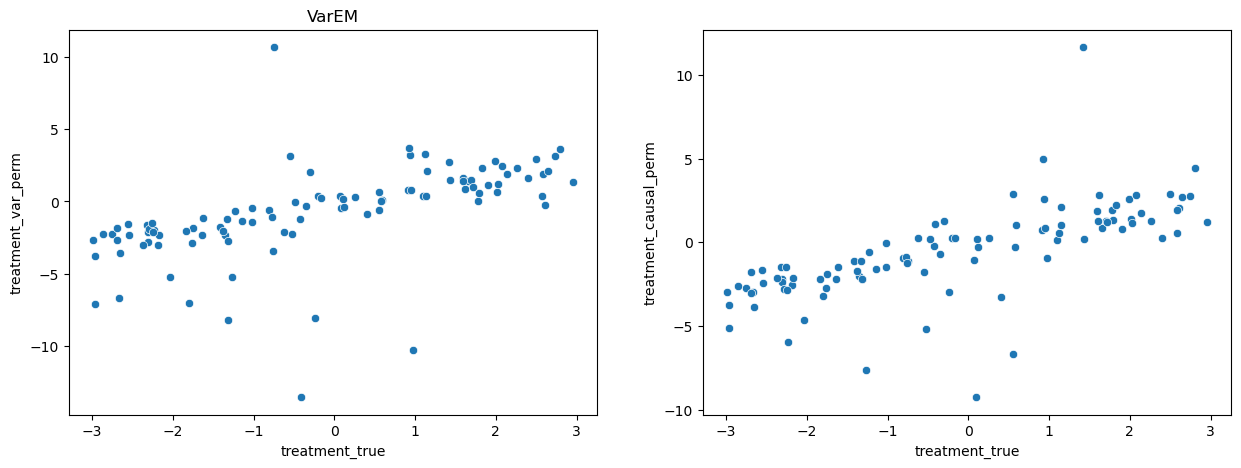

7.227191061599829
4.332024629942244


In [14]:
from sklearn.metrics import mean_squared_error
results = pd.read_csv("results_var_vs_causal.csv")
fig, ax = plt.subplots(1,2,figsize = (15,5)) 
sns.scatterplot(x=results.treatment_true, y=results.treatment_var_perm, ax = ax[0])
ax[0].title.set_text('VarEM')
sns.scatterplot(x=results.treatment_true, y=results.treatment_causal_perm, ax = ax[1])
ax[1].title.set_text('CausalVarEM')
plt.show()
print(mean_squared_error(results.treatment_true, results.treatment_var_perm))
print(mean_squared_error(results.treatment_true, results.treatment_causal_perm))

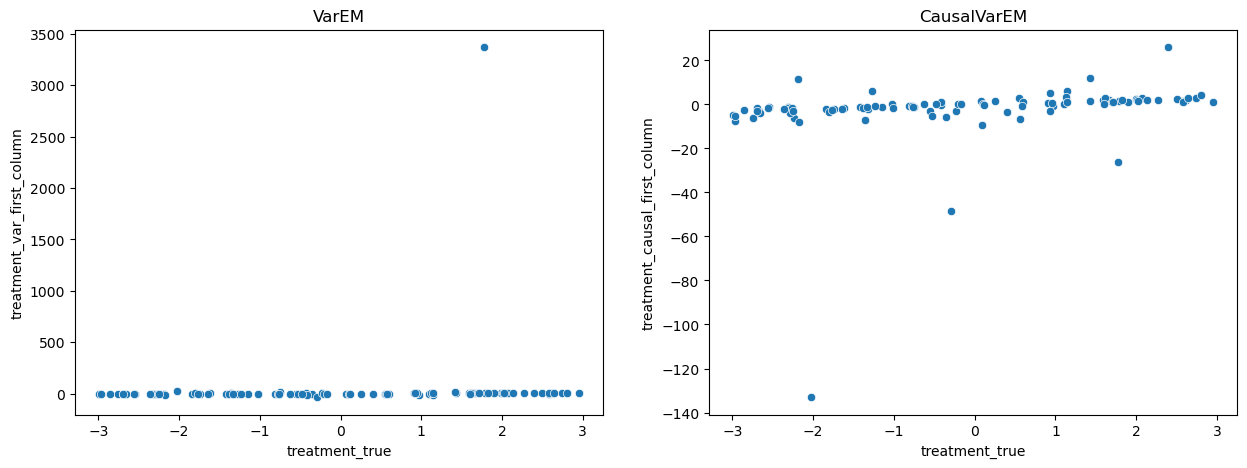

113459.66908495763
216.2025737018272


In [15]:
fig, ax = plt.subplots(1,2,figsize = (15,5))
sns.scatterplot(x=results.treatment_true, y=results.treatment_var_first_column, ax = ax[0])
ax[0].title.set_text('VarEM')
sns.scatterplot(x=results.treatment_true, y=results.treatment_causal_first_column, ax = ax[1])
ax[1].title.set_text('CausalVarEM')
plt.show()  
print(mean_squared_error(results.treatment_true, results.treatment_var_first_column))
print(mean_squared_error(results.treatment_true, results.treatment_causal_first_column))


In [17]:
ind_varEM = np.argmax(results.treatment_var_first_column)
ind_causal = np.argmin(results.treatment_causal_first_column)

In [20]:
results.treatment_var_first_column

0    -8.175358
1    -0.437114
2     2.775726
3    -1.838098
4    -0.330422
        ...   
95   -0.644206
96    0.030307
97    1.375218
98   -3.427269
99   -0.398152
Name: treatment_var_first_column, Length: 100, dtype: float64

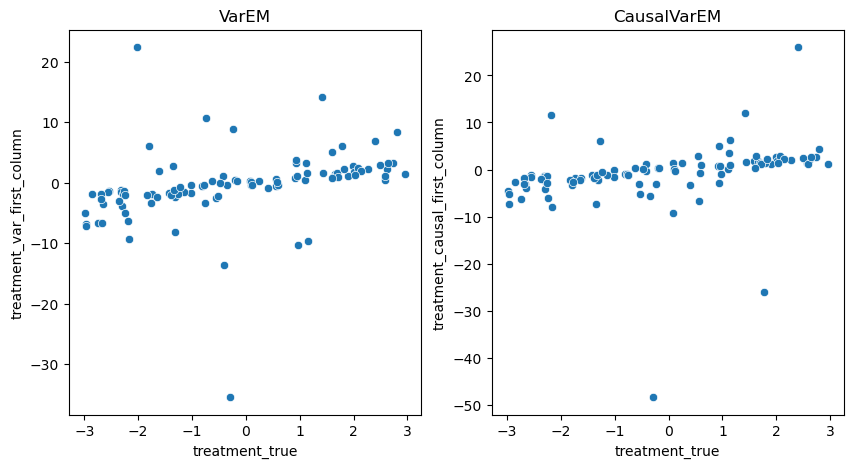

30.800336812791844
44.99373090797746


In [22]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
sns.scatterplot(x=results.treatment_true.drop(ind_varEM), y=results.treatment_var_first_column.drop(ind_varEM), ax=ax[0])
ax[0].title.set_text('VarEM')
sns.scatterplot(x =results.treatment_true.drop(ind_causal), y = results.treatment_causal_first_column.drop(ind_causal), ax = ax[1])
ax[1].title.set_text('CausalVarEM')
plt.show()
print(mean_squared_error(results.treatment_true.drop(ind_varEM), results.treatment_var_first_column.drop(ind_varEM)))
print(mean_squared_error(results.treatment_true.drop(ind_causal), results.treatment_causal_first_column.drop(ind_causal)))